## 使用OpenCV 讀取YOLOv3模型

* 使用dnn內的readNetFromDarknet(configPath, weightsPath) 讀取Darknet模型
    * configPath 為設定檔的路徑
    * weightsPath 為權重檔的路徑
* 使用getLayerNames 讀取出模型架構名稱
* 使用getUnconnectedOutLayers 讀取模型輸出層的位置，但在陣列中是從0開始索引編號，因此位置變為索引需要減一

## 讀取相關參數
* 讀取.name檔案得到標籤名稱
* 先定義三種標籤的顏色（紅、藍、綠色）

In [60]:
import cv2
import numpy as np

net = cv2.dnn.readNetFromDarknet("yolov3.cfg","./weights/yolov3_1100.weights")
#net = cv2.dnn.readNetFromDarknet("yolov3-tiny.cfg","./test_yolov3-tiny_10000.weights")

layer_names = net.getLayerNames()
#print(layer_names)

output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
print("輸出名稱：",output_layers)

輸出名稱： ['yolo_82', 'yolo_94', 'yolo_106']


In [61]:
classes = [line.strip() for line in open("cfg_mask/obj.names")]
#classes = [line.strip() for line in open("cfg_mask/obj2.names")]

print("標籤名稱:",classes)

colors = [(0,0,255),(255,0,0),(0,255,0)]

標籤名稱: ['none', 'bad', 'good']


## 讀取圖片

* 使用Image.open與.show呈現圖片
* 使用cv2.imread讀取影像轉為陣列
* 使用.shape 打印出陣列大小

In [62]:
from PIL import Image
img = Image.open('test.jpg')
#Image.open('test2.jpg')
img.show()

img = cv2.imread("test.jpg")
#img = cv2.imread("test2.jpg")
img.shape

(562, 1000, 3)

## 利用YOLOv3 模型辨識圖片
- 320 x 320 (high speed, less accuracy)
- 416 x 416 (moderate speed, moderate accuracy)
- 608 x 608 (less speed, high accuracy)

---
* 使用Opencv的.resize(src, dsize, fx, fy, interpolation) 改變陣列大小，fx,fy為縮放多少倍
* 使用Opencv的 dnn.blobFromImage(image, scalefactor, size, mean, swapRB, crop, ddepth) 對影像作預處理
    * image:輸入的影像
    * scalefactor:影像各通道數值的縮放比例
    * size:輸出影像的空間尺寸
    * mean:用於各通道減去的值
    * swapRB:交換RB通道，默認為False(cv2.imread讀取彩色影像為bgr通道)
    * crop:影像裁剪,默認為False，當值為True時，先按比例縮放，然後從中心裁剪成該大小尺寸
    * ddepth:輸出的影像深度，可選擇CV_32F 或者 CV_8U.


In [77]:
img = cv2.resize(img, None, fx=0.4, fy=0.4)
height, width, channels = img.shape
blob = cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), (0, 0, 0), True, crop=False)
print(blob.shape)
net.setInput(blob)
outs = net.forward(output_layers)
print("輸出的尺度數量：",len(outs))
print("輸出的bbox的數量與各長度：",outs[0].shape)

(1, 3, 416, 416)
輸出的尺度數量： 3
輸出的bbox的數量與各長度： (507, 8)


## 擷取偵測物件位置

In [64]:
%%html
<img src='https://miro.medium.com/max/1200/0*3A8U0Hm5IKmRa6hu.png' width="500px" />

In [65]:
class_ids = []
confidences = []
boxes = []
    
for out in outs:
    for detection in out:
        tx, ty, tw, th, confidence = detection[0:5]
        scores = detection[5:]
        class_id = np.argmax(scores)  
        if confidence > 0.3:   
            center_x = int(tx * width)
            center_y = int(ty * height)
            w = int(tw * width)
            h = int(th * height)
            
            # 取得箱子方框座標
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

In [66]:
len(boxes)

15

## non-maxima suppression
- 去除多餘重疊且信心度低的箱型區域 


<img src='https://miro.medium.com/max/1400/1*OZwJcNsMZc7wT733fA_ITg.png' width="500px" />


In [15]:
?cv2.dnn.NMSBoxes

In [67]:
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.3)
#indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.2, 0.6)

## 框住偵測物件區域

In [68]:
font = cv2.FONT_HERSHEY_TRIPLEX

for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        color = colors[class_ids[i]]
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img, label, (x, y - 5), font, 0.5, color, 1)

In [69]:
img.shape

(225, 400, 3)

Populating the interactive namespace from numpy and matplotlib


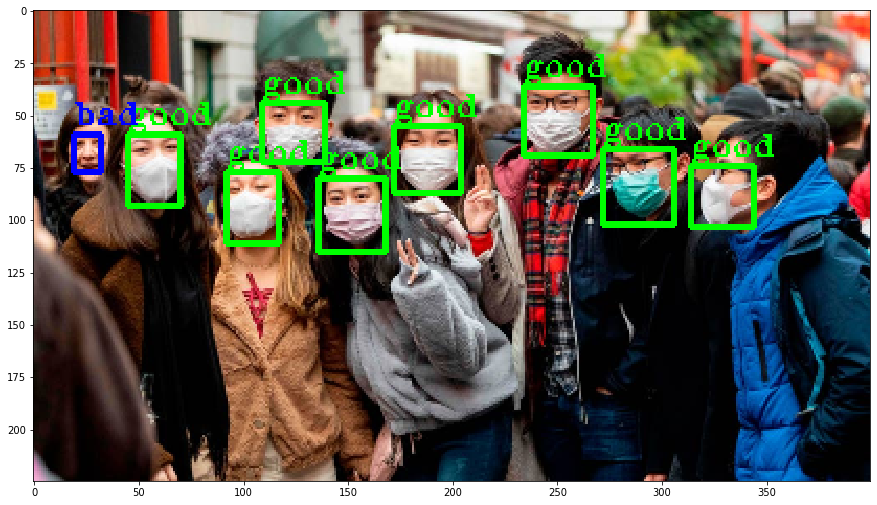

In [70]:
%pylab inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

## 將辨識過程包裝成函數

In [73]:
import cv2
import numpy as np
net = cv2.dnn.readNetFromDarknet("yolov3.cfg","./weights/yolov3_1100.weights")
#net = cv2.dnn.readNetFromDarknet("yolov3-tiny.cfg","./test_yolov3-tiny_10000.weights")

layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

classes = [line.strip() for line in open("cfg_mask/obj.names")]
#classes = [line.strip() for line in open("cfg_mask/obj2.names")]

colors = [(0,0,255),(255,0,0),(0,255,0)]

def yolo_detect(frame):
    
    img = cv2.resize(frame, None, fx=0.4, fy=0.4)
    height, width, channels = img.shape 
    
    blob = cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), (0, 0, 0), True, crop=False)
    #blob = cv2.dnn.blobFromImage(img, 1/255.0, (320, 320), (0, 0, 0), True, crop=False)
    
    net.setInput(blob)
    outs = net.forward(output_layers)

    class_ids = []
    confidences = []
    boxes = []
    
    for out in outs:
        for detection in out:
            tx, ty, tw, th, confidence = detection[0:5]
            
            scores = detection[5:]
            class_id = np.argmax(scores)  
            if confidence > 0.5:   
                center_x = int(tx * width)
                center_y = int(ty * height)
                w = int(tw * width)
                h = int(th * height)

                # 取得箱子方框座標
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
                
    # draw boxes
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.3)
    #indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.2, 0.6)
    
    font = cv2.FONT_HERSHEY_PLAIN
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = colors[class_ids[i]]
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
            cv2.putText(img, label, (x, y -5), font, 0.5, color, 1)
    return img

## 測試函數功能

0.5997679233551025


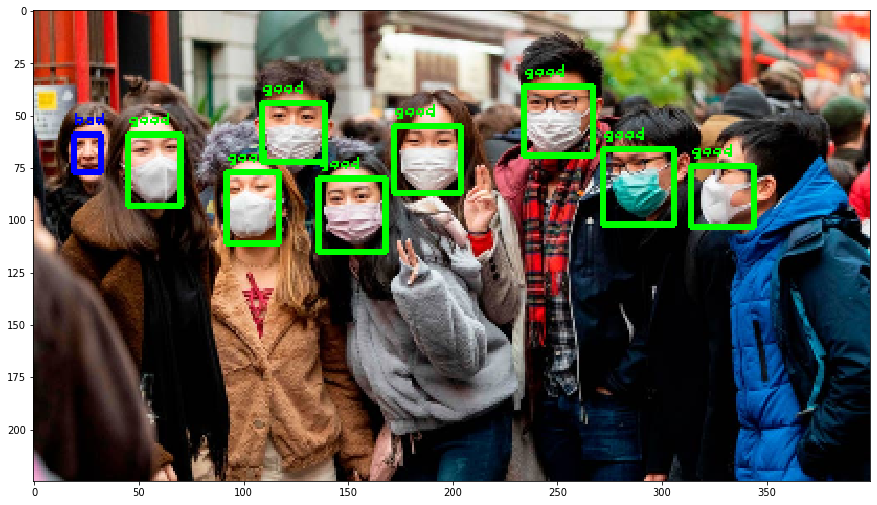

In [74]:
import time
from matplotlib import pyplot as plt

img = cv2.imread("test.jpg")
#img = cv2.imread("test.jpg")

#紀錄時間：開始
start = time.time()

im = yolo_detect(img)

#紀錄時間：結束
end = time.time()

#呈現時間
print(end-start)

img_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

## 使用攝像頭即時偵測物件

In [2]:
import cv2
import time

VIDEO_IN = cv2.VideoCapture(0)
#VIDEO_IN = cv2.VideoCapture("Video2.mp4") 

while True:
    hasFrame, frame = VIDEO_IN.read()
    
    #start = time.time()
    
    img = yolo_detect(frame)
    cv2.imshow("Frame", img)
    #cv2.imshow("Frame", frame)
    
    #end = time.time()
    #print(end-start)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
VIDEO_IN.release()
cv2.destroyAllWindows()